In [1]:
from sqlalchemy import create_engine
import datetime as datetime 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize,PolynomialFeatures,OneHotEncoder,LabelBinarizer
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import validation_curve,learning_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score,precision_score,classification_report,f1_score,classification_report,log_loss
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import compress
sns.set()
plt.style.use("fivethirtyeight")
%matplotlib inline

/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  

In [2]:
input_train_df=pd.read_pickle("input_train_df.pkl")

In [23]:
input_train_df.head(3)

,dates,category,descript,dayofweek,pddistrict,resolution,address,x,y,crime_event
0,2015-05-13 23:53:00,REST,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,1
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,1


In [24]:
# Extracting the maximum granularity from date time
input_train_df["hour"]=input_train_df.dates.apply(lambda x: x.hour)
input_train_df["week"]=input_train_df.dates.apply(lambda x: x.week)
input_train_df["year"]=input_train_df.dates.apply(lambda x: x.year)
input_train_df["minutes"]=input_train_df.dates.apply(lambda x: x.minute)
input_train_df["seconds"]=input_train_df.dates.apply(lambda x: x.second)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

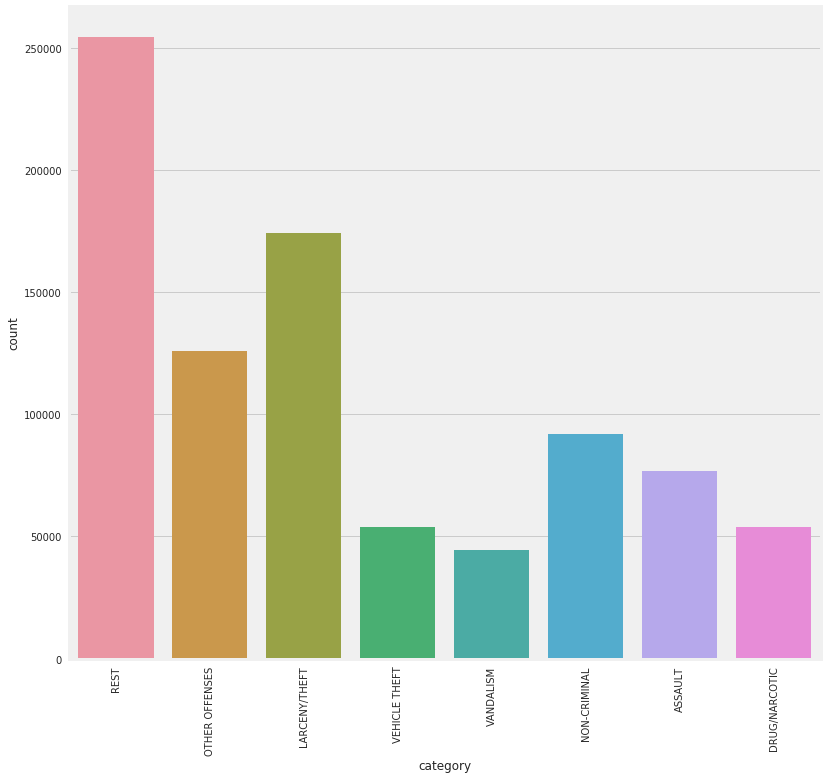

In [25]:
plt.figure(figsize=(12,12))
sns.countplot(input_train_df.category);
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),
 <a list of 62 Text xticklabel objects>)

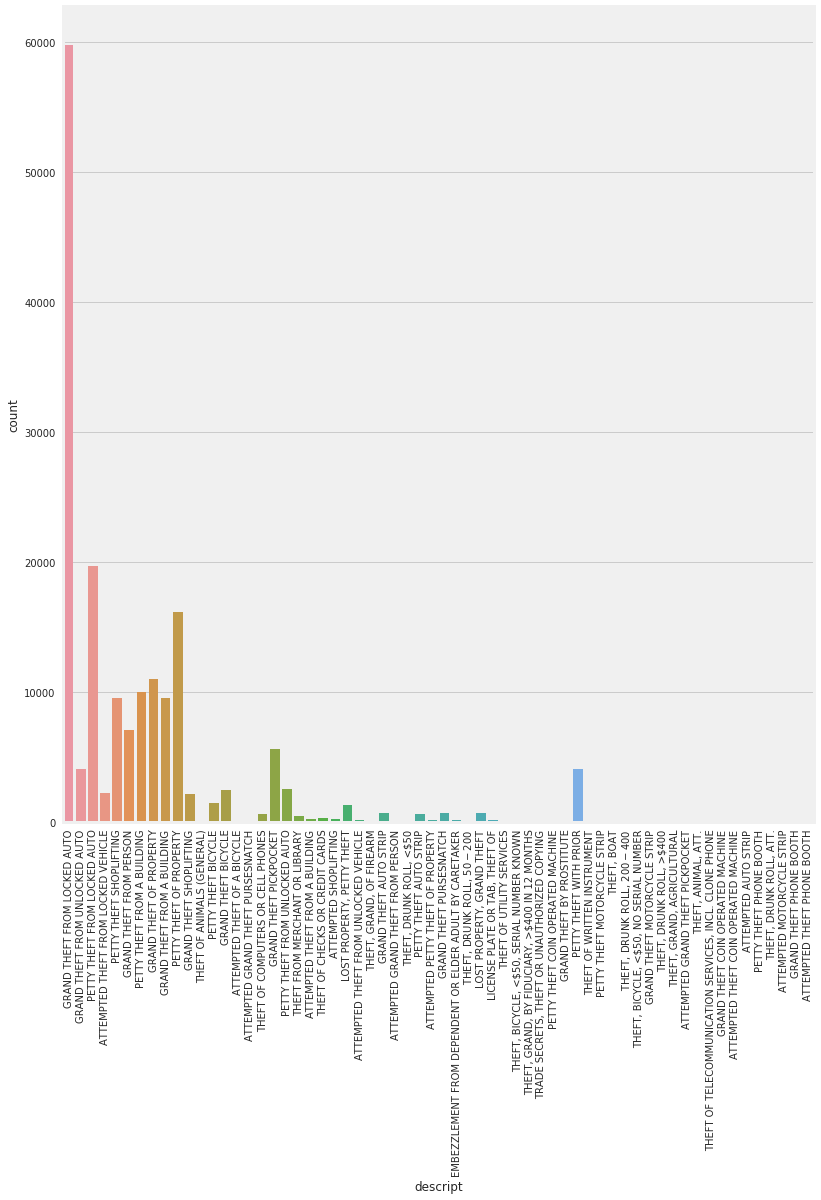

In [26]:
plt.figure(figsize=(12,15))
sns.countplot(input_train_df[input_train_df.category=='LARCENY/THEFT'].descript,orient='v');
plt.xticks(rotation=90,)


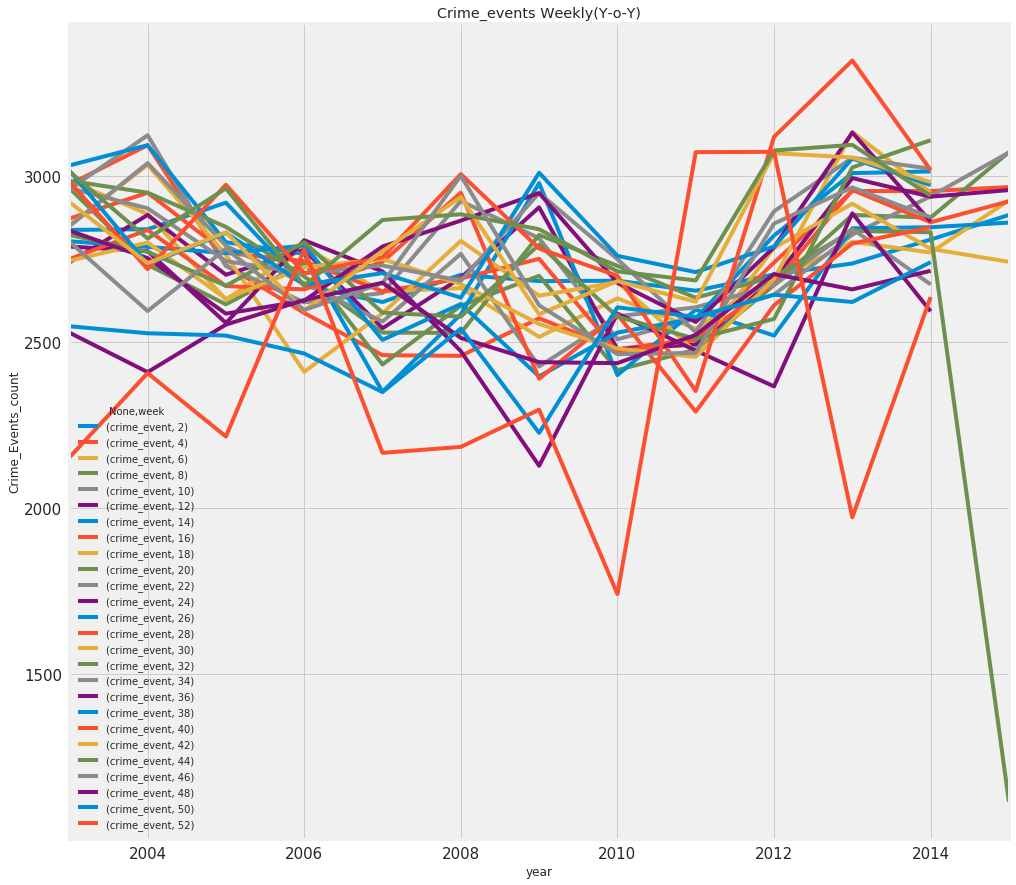

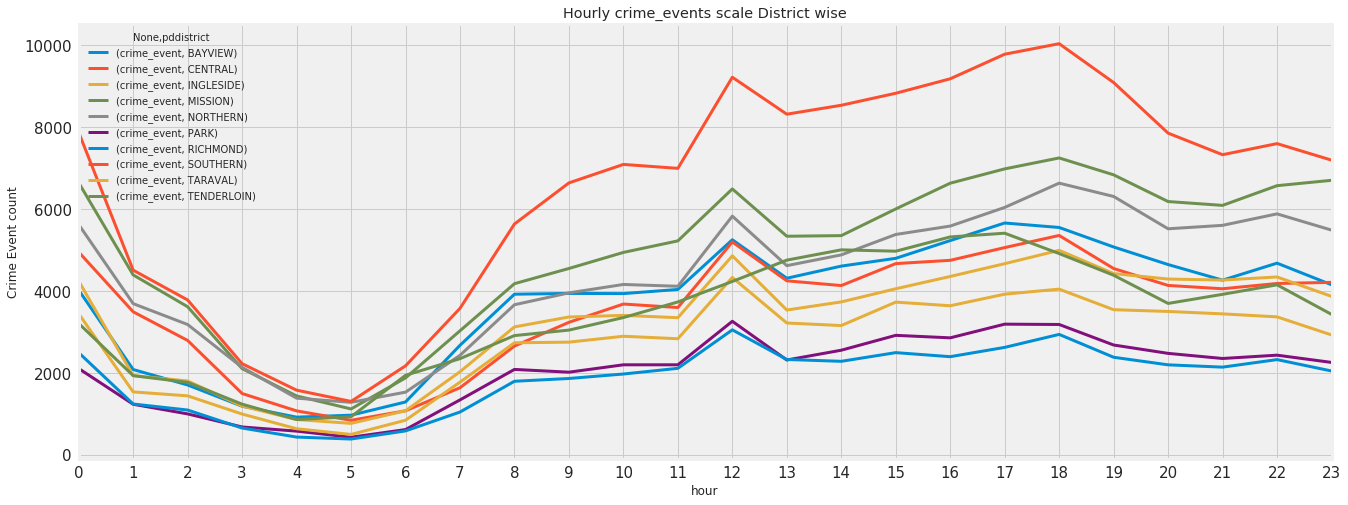

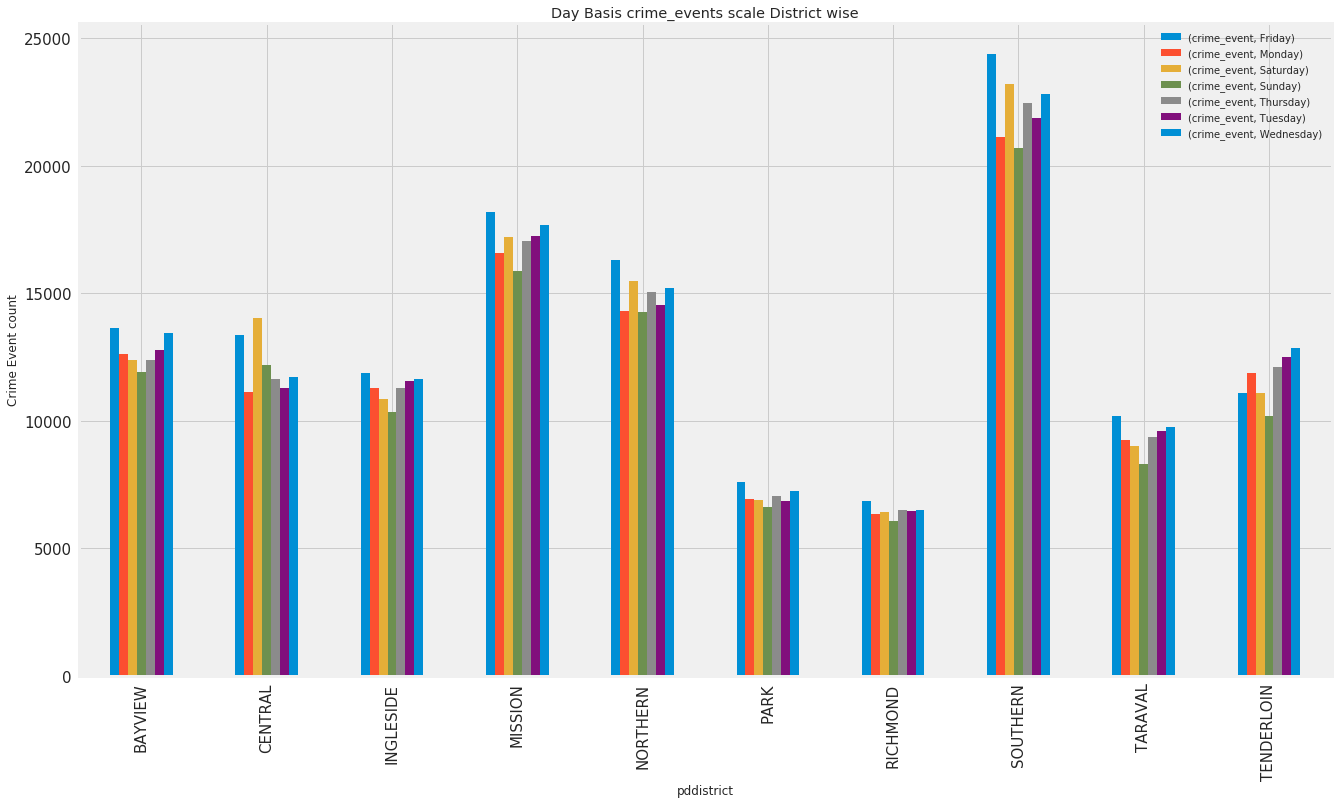

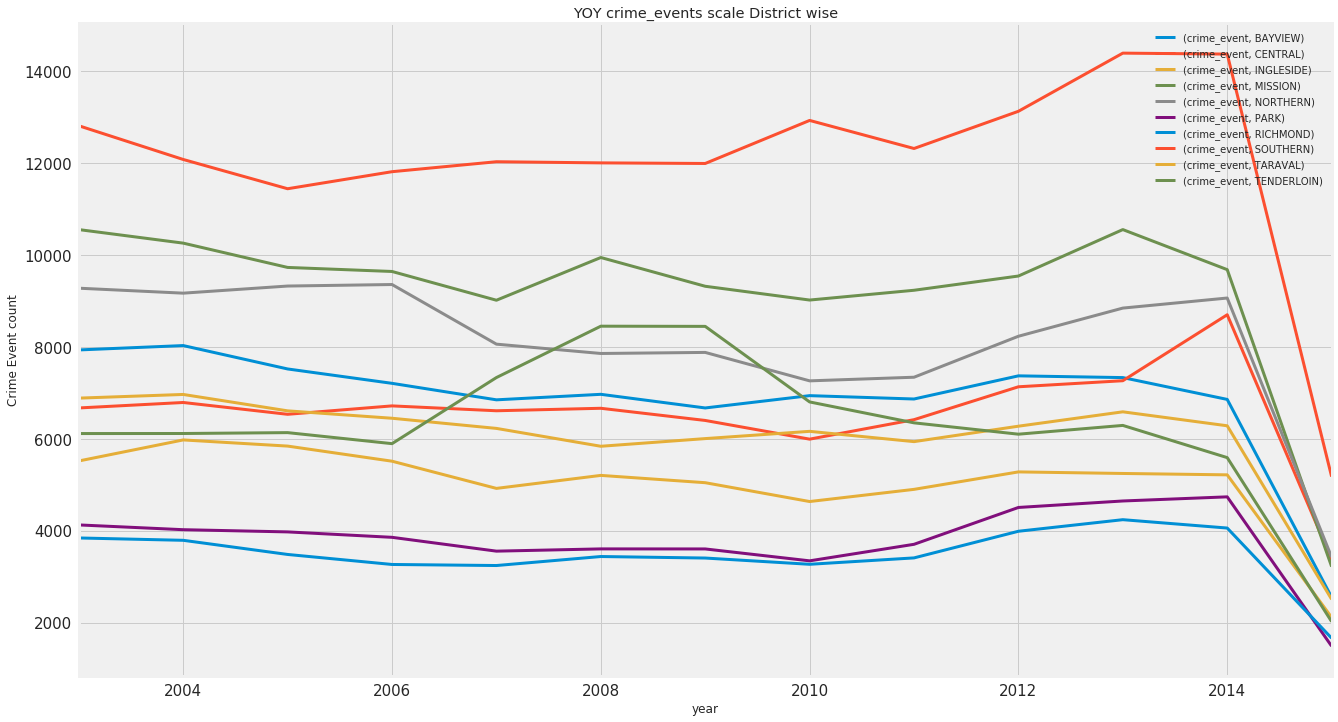

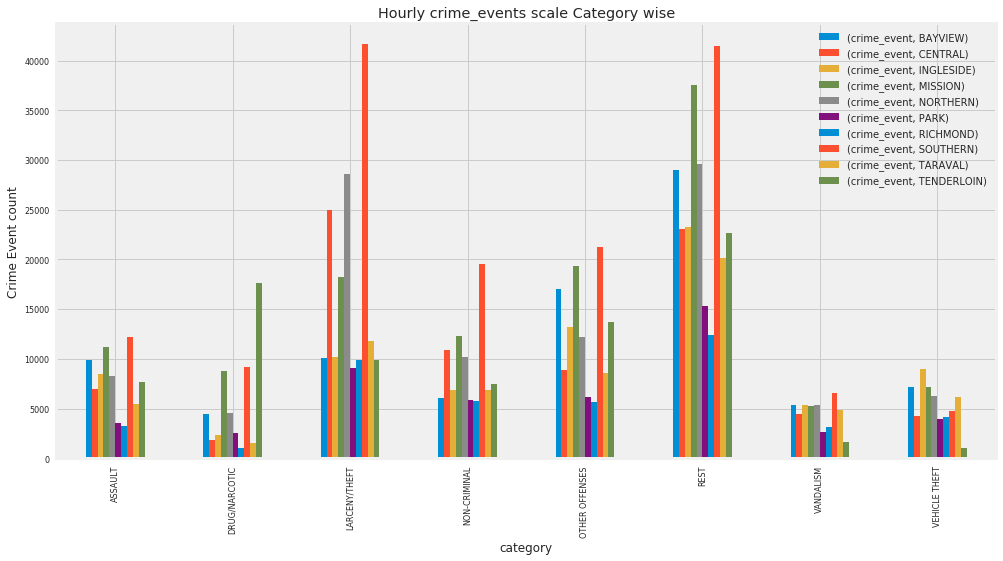

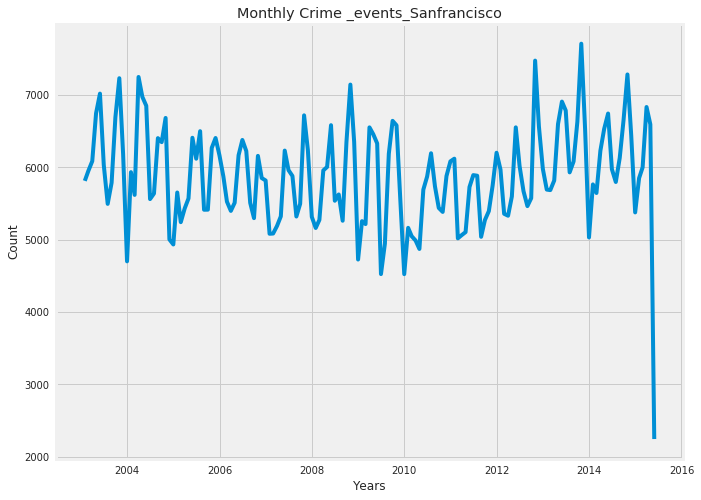

In [27]:
by_year_week=input_train_df.groupby(["year","week"])["crime_event"].size().reset_index()
by_year_week.pivot_table(index="year",columns="week").plot(figsize=(15,15),title="Crime_events Weekly(Y-o-Y)",fontsize=15)
plt.ylabel("Crime_Events_count")
plt.show()

by_district_hour=input_train_df.groupby(["pddistrict","hour"])['crime_event'].size().reset_index()
by_district_hour.pivot_table(index='hour',columns="pddistrict").plot(figsize=(20,8),fontsize=15,linewidth=3)
plt.title("Hourly crime_events scale District wise")
plt.ylabel("Crime Event count")
plt.xticks(np.arange(0,24,1));
plt.show()

by_district_week=input_train_df.groupby(["pddistrict","dayofweek"])['crime_event'].size().reset_index()
by_district_week.pivot_table(columns='dayofweek',index="pddistrict").plot.bar(figsize=(20,12),fontsize=15,linewidth=3,)
plt.legend(loc='best')
plt.title("Day Basis crime_events scale District wise")
plt.ylabel("Crime Event count")
plt.show()

by_district_year=input_train_df.groupby(["pddistrict","year"])['crime_event'].size().reset_index()
by_district_year.pivot_table(index='year',columns="pddistrict").plot(figsize=(20,12),fontsize=15,linewidth=3,)
plt.legend(loc='best')
plt.title("YOY crime_events scale District wise")
plt.ylabel("Crime Event count")
plt.show()

by_descript_hour=input_train_df.groupby(["category","pddistrict"])['crime_event'].size().reset_index()
by_descript_hour.pivot_table(index='category',columns="pddistrict").plot.bar(figsize=(15,8),fontsize=8,linewidth=3,)
plt.legend(loc='best')
plt.title("Hourly crime_events scale Category wise")
plt.ylabel("Crime Event count")
plt.autoscale(axis='y')
#plt.xticks(np.arange(0,24,1));
plt.show()

resample_df=input_train_df.copy(deep=True)

resample_df.index=resample_df.dates
resample_df.drop("dates",axis=1,inplace=True)


plt.figure(figsize=(10,8))
plt.title("Monthly Crime _events_Sanfrancisco")
plt.ylabel("Count")
plt.xlabel("Years")
plt.plot(resample_df.resample("M")["crime_event"].sum())
plt.show()



Number of categories(features):  8


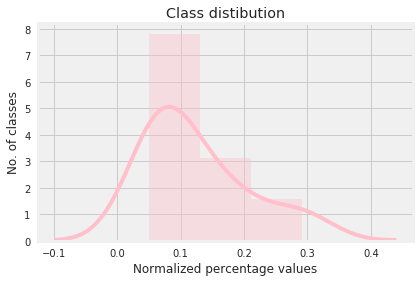

In [17]:

print("Number of categories(features): ", len(input_train_df.category.value_counts().index))
plt.title("Class distibution")
plt.ylabel("No. of classes")

sns.distplot(input_train_df.category.value_counts(normalize=True),kde=True,norm_hist=False,color='pink');
plt.xlabel("Normalized percentage values");

In [29]:
#converting weekdays in sparse matrix using label binarizer
labelB=LabelBinarizer()
lb=labelB.fit(input_train_df.dayofweek)
lbclass=lb.classes_
lb=labelB.transform(input_train_df.dayofweek)

input_train_df=input_train_df.join(pd.DataFrame(lb,columns=lbclass))

In [30]:
#Converitng pd district too spare matirx
pdd=pd.get_dummies(input_train_df.pddistrict)
input_train_df=input_train_df.join(pdd)

In [31]:
tfid=TfidfVectorizer(stop_words='english',max_features=1000,)
word_vector=tfid.fit(input_train_df.address)
word_names=word_vector.get_feature_names
word_vector=word_vector.transform(input_train_df.address)
word_vector.shape

(875647, 1000)

In [32]:
vector_final=pd.DataFrame(word_vector.toarray())
input_train_df=input_train_df.drop(["descript","dayofweek","pddistrict","resolution","address","dates"],axis=1)
input_train_df=input_train_df.join(vector_final)

** Subsetting the data randomly**  

In [33]:
subset_size=0.15
index_range=np.random.choice(input_train_df.shape[0],int(input_train_df.shape[0]*subset_size))

In [34]:
i=input_train_df.iloc[index_range]

In [35]:
i.dropna(inplace=True)

/home/ubuntu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
X=i.drop("category",axis=1)
Y=i.category
X_train, X_test, y_train, y_test=train_test_split(X,Y,train_size=0.8,random_state=42)

#required for decision tree after subsetting the data
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


**Logistic Regression**

In [37]:
lgr=LogisticRegression(C=10,class_weight="balanced")
lgr.fit(X_train,y_train)
y_pred_logitsic=lgr.predict(X_test)

In [38]:
print("Baseline for Logistic_regression")
print(classification_report(y_test,y_pred_logitsic))

Baseline for Logistic_regression
                precision    recall  f1-score   support

       ASSAULT       0.11      0.05      0.07      2307
 DRUG/NARCOTIC       0.18      0.45      0.26      1624
 LARCENY/THEFT       0.32      0.45      0.38      5294
  NON-CRIMINAL       0.16      0.01      0.03      2792
OTHER OFFENSES       0.20      0.12      0.15      3718
          REST       0.34      0.22      0.27      7549
     VANDALISM       0.06      0.05      0.05      1340
 VEHICLE THEFT       0.13      0.43      0.20      1581

   avg / total       0.24      0.23      0.21     26205



** Random Forest Classifier**  

In [39]:
ranforest=RandomForestClassifier(min_samples_leaf=5,n_estimators=200,)
ranforest.fit(X_train,y_train)
y_pred_random_forest=ranforest.predict(X_test)
y_probs_random_forest=ranforest.predict_proba(X_test)

#recall_score(y_test,y_pred_random_forest,average="macro")
print("Baseline for Random Forest")
print(classification_report(y_test,y_pred_random_forest))

Baseline for Random Forest
                precision    recall  f1-score   support

       ASSAULT       0.00      0.00      0.00      2307
 DRUG/NARCOTIC       0.38      0.18      0.24      1624
 LARCENY/THEFT       0.39      0.46      0.42      5294
  NON-CRIMINAL       0.00      0.00      0.00      2792
OTHER OFFENSES       0.52      0.00      0.01      3718
          REST       0.31      0.79      0.45      7549
     VANDALISM       0.00      0.00      0.00      1340
 VEHICLE THEFT       0.47      0.03      0.06      1581

   avg / total       0.30      0.34      0.24     26205



/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
feat_imp_random=pd.DataFrame(list(zip(X_train.columns,ranforest.feature_importances_)),columns=["features","feat_score"])
#feat_imp_random[feat_imp_random["feat_score"]>0].plot(kind="bar")


**XGBoost**  

In [ ]:
# gbm = XGBClassifier( 
#                        n_estimators=300, #arbitrary large number
#                        max_depth=3,
#                        objective="multi:softmax",
#                        learning_rate=.1, 
#                        subsample=1,
#                        min_child_weight=1,
#                        colsample_bytree=.8
#                       )

# eval_set=[(X_train,y_train),(X_test,y_test)] #tracking train/validation error as we go
# fit_model = gbm.fit( 
#                     X_train, y_train, 
#                     eval_set=eval_set,
#                     eval_metric='mlogloss',
#                     early_stopping_rounds=50,
#                     verbose=True #gives output log as below
#                    )

In [ ]:
#from sklearn.metrics import recall_score, auc,roc_curve
#print(classification_report(y_test,fit_model.predict(X_test)))
#print(classification_report(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test))

## **Relational Database Scrapped**

**ZIP CODES**  
**Median Income(by zip code)**  
**Male_Population**  
**Female_Population**  

In [41]:
relational_zipcode_df=pd.read_pickle("relational_zipcode_df.pkl",)
zipper_df=pd.read_pickle("zip_code_unique.pkl")
zipper_df.columns=["zipcode","Y","X"]

zipcode=pd.merge(zipper_df,relational_zipcode_df,how="left",left_on=["zipcode"],right_on=["Zipcode"])
zipcode.drop("zipcode",axis=1,inplace=True)
zipcode.Zipcode=zipcode.Zipcode.apply(lambda x: int(x))

input_train_merged_df=pd.merge(input_train_df,zipcode,how='left',left_on=["x","y"],right_on=["X","Y"])
input_train_merged_df.dropna(inplace=True)

# Wrong zip codes
input_train_merged_df=input_train_merged_df[input_train_merged_df.Zipcode>9000]

In [42]:
input_train_merged_df.Male_population=input_train_merged_df.Male_population.apply(lambda x: x.replace("","99999999999999"))
input_train_merged_df.Male_population=input_train_merged_df.Male_population.apply(lambda x: float(x))

input_train_merged_df.Female_population=input_train_merged_df.Female_population.apply(lambda x: x.replace("","99999999999999"))
input_train_merged_df.Female_population=input_train_merged_df.Female_population.apply(lambda x: float(x))

input_train_merged_df.Median_income_zipcode=input_train_merged_df.Median_income_zipcode.apply(lambda x: x.replace("","99999999999999"))
input_train_merged_df.Median_income_zipcode=input_train_merged_df.Median_income_zipcode.apply(lambda x: float(x))

In [43]:
input_train_merged_df=input_train_merged_df[input_train_merged_df.Median_income_zipcode<99999999999999]
input_train_merged_df=input_train_merged_df[input_train_merged_df.Female_population<99999999999999]
input_train_merged_df=input_train_merged_df[input_train_merged_df.Male_population<99999999999999]